# FRB 20220121aaat (model with no scattering)

In [1]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import gauss, gauss_norm, pulse_fn_vec, sgram_fn_vec, sgram_fn
from burstfit.utils.plotter import plot_fit_results, plot_2d_fit 
from burstfit.io import BurstIO
import logging
import numpy as np
import math
import matplotlib.pyplot as plt
# use Liam's function to read in filterbank files 
import sys
sys.path.insert(1, '/home/ubuntu/gechen/software')
import filplot_funcs_gc as ff

#from burstfit.utils.functions import gauss_norm2, pulse_fn_vec, sgram_fn_vec 
%matplotlib inline 


# input variables 
candidate = '220121aaat'
datestring = '2022_1_21_5_1_21'
beam = 100 
corr = 'corr02'
dm_heimdall = 313.4
width_heimdall = 8 
snr_heimdall = 9.4 
mask_chans=[] 

fil_file ='/data/dsa110/T1/'+corr + '/' + datestring + '/fil_'+candidate+'/'+candidate+'_'+str(beam)+'.fil'
save_name = candidate + '_beam_'+str(beam)
save_dir = '/home/ubuntu/gechen/burstfit_tests_outputs/' 


#data = ff.proc_cand_fil(fil_file, dm, width, nfreq_plot=64, ndm=64)[0]
#data_t = data.mean(0)

logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=logging_format,
)
# create burst object 
bd = BurstData(
    fp=fil_file,
    dm=dm_heimdall ,
    tcand=0.5, # pulse starting time in s.
    width=width_heimdall,  
    snr=snr_heimdall
)

bd.prepare_data()

# number of channels after binning 
# requires each channel bin to have SNR_min 
# snr_heimdall was calculated with all 256 channels binned into one 
SNR_min = 3 
n_per_bin = int(256 / (snr_heimdall / SNR_min)**2) 
if not math.log(n_per_bin, 2).is_integer():
    n_per_bin = 2 ** (int(np.log2(n_per_bin))+1)
nfreq = int(256 / n_per_bin) 
print(nfreq)
    
# read in data 
data = ff.proc_cand_fil(fil_file, bd.dm, bd.width, nfreq_plot=nfreq, ndm=64)[0]
# zoom in close to the burst 
data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)]
#data_burst = data 
    
# fit models  
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel

# ues gaussian pulse without scattering convolution: 
pnames = ['S', 'mu_t', 'sigma_t']
pulseModel = Model(gauss, param_names=pnames)

# For spectra, we will use a normalized gaussian model  
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)


sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])

#sgram_bounds=((0, 0.45, 0, -np.inf),(np.inf, 0.55, np.inf, np.inf)) # did not work when only set up bounds but do not chop data 

# Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 
# initial fit: use heimdall results 
bf = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False
)

print('bf.ncomponents=%d'%bf.ncomponents)
print(data_burst)

# Some setting up before we do the fitting 
bf.validate()
bf.precalc()

/home/ubuntu/gechen/software/filplot_funcs_gc.py:20: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


datacite/tind env not found. Cannot use datacite API


2022-02-15 21:12:50,291 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2022-02-15 21:12:50,341 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.2s.
2022-02-15 21:12:50,344 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2022-02-15 21:12:50,362 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (32.94796335893984, 22.55808984402352)


8
bf.ncomponents=0
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-2.3965838  -0.05405828  2.2163897  ...  1.5496708  -0.7207771
   1.225321  ]
 [-1.9641176   0.21623313 -0.7748354  ... -1.2973988  -0.41444683
   1.6397679 ]
 ...
 [-0.07207771 -0.54058284 -1.0811657  ... -0.21623313 -1.4775931
  -1.4055153 ]
 [-0.21623313  1.1712627   0.43246627 ...  0.7207771   0.7928548
   0.5586023 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


2022-02-15 21:13:23,262 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-02-15 21:13:23,265 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-02-15 21:13:23,294 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2022-02-15 21:13:23,296 - initial_profilefit -burstfit.fit - INFO - S: -3847908802.302011 +- 8703721387999.018
2022-02-15 21:13:23,297 - initial_profilefit -burstfit.fit - INFO - mu_t: -116.12521832443254 +- 14898.094851479
2022-02-15 21:13:23,299 - initial_profilefit -burstfit.fit - INFO - sigma_t: 19.778755455898224 +- 1239.6248016267011


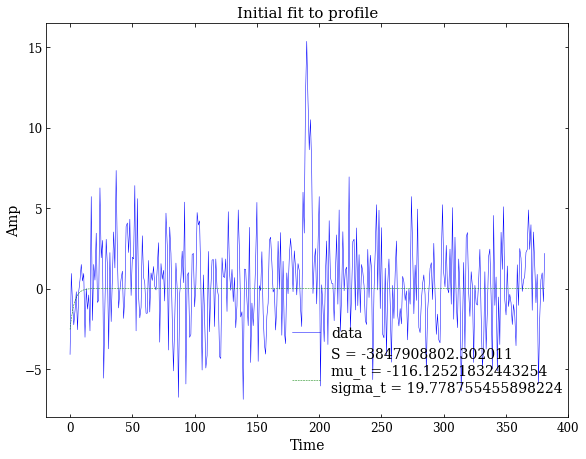

2022-02-15 21:13:23,536 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-02-15 21:13:23,542 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2022-02-15 21:13:23,553 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-02-15 21:13:23,556 - initial_spectrafit -burstfit.fit - INFO - mu_f: 4.399262733341451 +- 0.36119331824910306
2022-02-15 21:13:23,558 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 1.4644655944496454 +- 0.2982142362519213


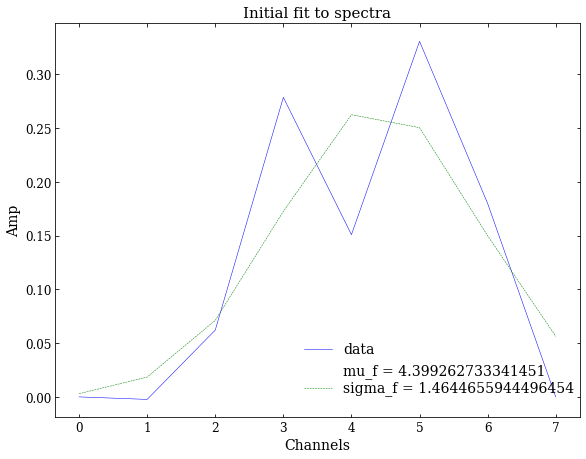

2022-02-15 21:13:23,758 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-02-15 21:13:23,761 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [4.399262733341451, 1.4644655944496454, -3847908802.302011, -116.12521832443254, 19.778755455898224, 313.4]
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
2022-02-15 21:13:23,778 - run_fit -burstfit.curvefit - WARNING - Fit errors are not finite. Retrying with p0+-(0.2*p0) bounds
2022-02-15 21:13:23,792 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-02-15 21:13:23,795 - sgram_fit -burstfit.fit - INFO - mu_f: 4.399262733341451 +- 0.0
2022-02-15 21:13:23,797 - sgram_fit -burstfit.fit - INFO - sigma_f: 1.4644655944496454 +- 0.0
2022-02-15 21:13:23,800 - sgram_fit -burstfit.fit - INFO - S: -3847908802.302011 +- 0.0
2022-02-15 21:13:23,802 - 

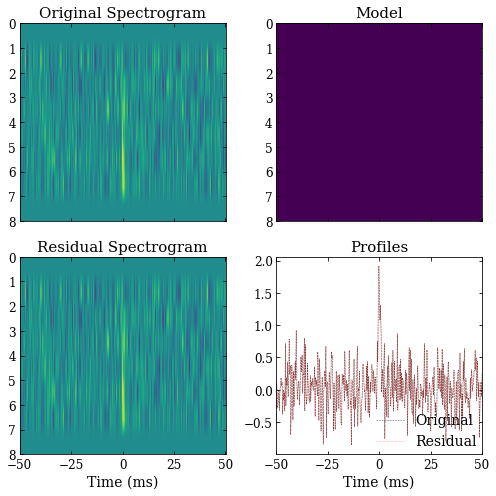

2022-02-15 21:13:24,341 - model -burstfit.fit - INFO - Making model.
2022-02-15 21:13:24,344 - model -burstfit.fit - INFO - Found 1 components.
2022-02-15 21:13:24,348 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-02-15 21:13:24,351 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-02-15 21:13:24,353 - model -burstfit.fit - INFO - Making model.
2022-02-15 21:13:24,355 - model -burstfit.fit - INFO - Found 1 components.
2022-02-15 21:13:24,359 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0365117283560406
2022-02-15 21:13:24,361 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-02-15 21:13:24,362 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-02-15 21:13:24,367 - tests -root - INFO - P values: T-test (0.09416), Kruskal (0.05659), KS (0.04541), F-test (0.36453)
2022-02-15 21:13:24,369 - run

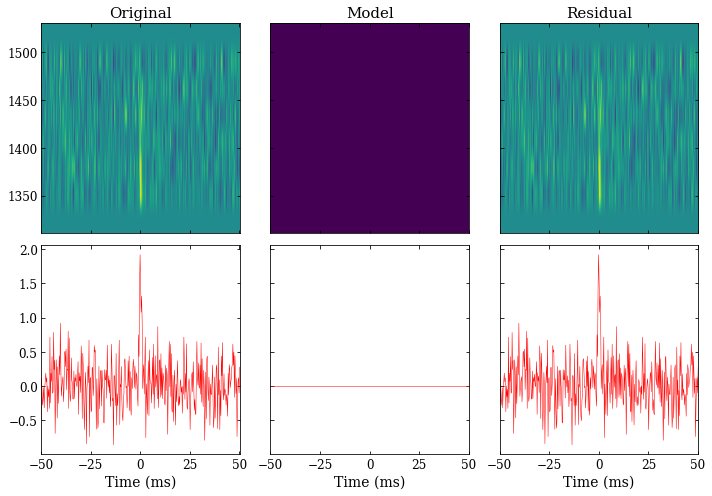

In [2]:
bf.fitcycle(plot=True)

# fit all componnts 
bf.fitall(plot=False) 
bf.calc_redchisq()
plot_fit_results(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
                 bf.tsamp, bf.fch1, bf.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
#dm_fit, dm_fit_err = bf.sgram_params['all'][1]['popt'][-1], bf.sgram_params['all'][1]['perr'][-1]


2022-02-15 21:14:21,540 - model -burstfit.fit - INFO - Making model.
2022-02-15 21:14:21,546 - model -burstfit.fit - INFO - Found 1 components.


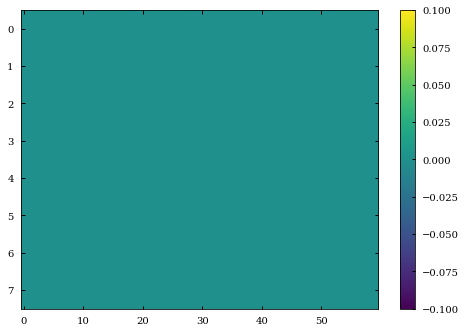

expected despersion in tsamp: 1.4 time samples


2022-02-15 21:14:21,834 - model -burstfit.fit - INFO - Making model.
2022-02-15 21:14:21,837 - model -burstfit.fit - INFO - Found 1 components.


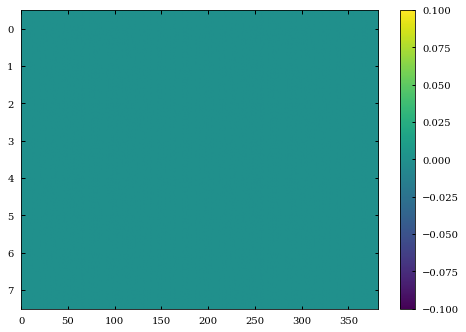

6

In [4]:
bf.sgram_params
plot_me(bf.model[:,int(382/2-30): int(382/2+30)]) 
bd.tsamp*3*1e3

dm_diff = 103.46597098341815 - 103
print('expected despersion in tsamp: %.1f time samples'%(4.149e3*dm_diff*(1/1280**2 - 1/1530**2) / bd.tsamp)) 

plot_me(bf.model)

bf.sgram_params

sgramModel.nparams


In [3]:
pnames = ['S', 'mu_t', 'sigma_t']
pulseModel = Model(pulse_fn_vec, param_names=pnames)

# For spectra, we will use a normalized gaussian model  
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)


sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])


bf = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False
)

print(np.shape(data_burst))

# Some setting up before we do the fitting 
bf.validate()
bf.precalc()
print('bf.ncomponents=%d'%bf.ncomponents)


AssertionError: Length of param_names is not equal to number of input parameters of the function.

In [ ]:
bf.fitcycle(plot=False)
print('bf.ncomponents=%d'%bf.ncomponents)

# fit all componnts 
bf.fitall(plot=False) 
print('bf.ncomponents=%d'%bf.ncomponents)

bf.sgram_params

In [ ]:
# MCMC 
# nwalker >= dimention + 1 
# nstep until getting smooth parameter distributions 
mcmc_kwargs = {}
mcmc_kwargs = {'nwalkers':60, 'nsteps':int(1e4),
           'skip':500, 'ncores':4, 
           'start_pos_dev':0.01,
           'prior_range':0.8, 
           'save_results':True,
           'outname':'test_file'}

bf.run_mcmc(plot=True, **mcmc_kwargs)



In [ ]:
# save fitting results 
bd.prepare_data()
bio = BurstIO(bf, bd)
d = bio.save_results(outname=save_name+"_fit_results.json", outdir=save_dir)  

In [ ]:
# do not delete this cell. 
# fit again using the new DM result dm_fit
# data, datadm, tsdm0, dms, datadm0 = ff.proc_cand_fil(fil_file, dm_fit, bd.width, nfreq_plot=nfreq, ndm=32)
# data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)]
# bf.sgram = data_burst
# bf.dm = dm_fit
# bd.dm = dm_fit 

# plt.plot(range(len(data_burst.mean(0))), data_burst.mean(0))
# plt.xlabel('Time Sample using new DM')

# bf.fitall(plot=False)
# plot_fit_results(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
#                  bf.tsamp, bf.fch1, bf.foff, show=True, save=True, outname=save_name+'2d_fit_res'+'_dm_burstfit', outdir=save_dir)


In [ ]:
bf.mcmc_params
d['param_names']

In [ ]:
# saving key burst paramters 
mu_f_mcmc, sigma_f_mcmc, s_mcmc, mu_t_mcmc, sigma_t_mcmc, tau_mcmc, dm_mcmc = bf.mcmc_params[1]['popt']
mu_f_mcmc_err, sigma_f_mcmc_err, s_mcmc_err, mu_t_mcmc_err, sigma_t_mcmc_err, tau_mcmc_err, dm_mcmc_err = bf.mcmc_params[1]['perr']

t0 = 0.45 + mu_t_mcmc * bd.tsamp
t0_err = [i * bd.tsamp for i in mu_t_mcmc_err] 

width_ms = sigma_t_mcmc * bd.tsamp * 1e3 # in ms
width_ms_err = [i * bd.tsamp for i in sigma_t_mcmc_err] 

# with open(save_dir+save_name+"_fit_key_results.txt") as f:
#     print('mu_f_mcmc, sigma_f_mcmc, s_mcmc, mu_t_mcmc, sigma_t_mcmc, tau_mcmc, dm_mcmc')
#     print(bf.mcmc_params[1]['popt'])
#     print('lower, upper bounds')
#     print(bf.mcmc_params[1]['perr'])

#outname=save_name+"_fit_results.json", outdir=save_dir

In [ ]:
rms_res = np.sqrt(sum(bf.residual.mean(0)**2) / len(bf.residual.mean(0)))

rms_res = np.sqrt(sum(data.mean(0)**2) / len(data.mean(0)))

snr = max(bf.model.mean(0)) / rms_res 

In [ ]:
print(np.sqrt(sum(data.mean(0)**2) / len(data.mean(0))))
print(np.sqrt(sum(bf.residual.mean(0)**2) / len(bf.residual.mean(0))))
print(max(data.mean(0)))

In [ ]:
sum(bf.residual.mean(0)**2) / len(bf.residual.mean(0))
dm_mcmc
sigma_t_mcmc

In [ ]:
data_mcmc_dm = ff.proc_cand_fil(fil_file, dm_mcmc, sigma_f_mcmc, nfreq_plot=nfreq, ndm=32)[0]


In [ ]:
#snr_himdall?  
max(data_mcmc_dm.mean(0)) / np.sqrt(sum(data_mcmc_dm.mean(0)**2) / len(data_mcmc_dm.mean(0)))



In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(range(len(data.mean(0)[int(0.48/bd.tsamp): int(0.52/bd.tsamp)])), data.mean(0)[int(0.48/bd.tsamp): int(0.52/bd.tsamp)])
ax[0].set_title('Using heimdall DM: SNR=%d?'%bd.snr)

ax[1].plot(range(len(data_mcmc_dm.mean(0)[int(0.48/bd.tsamp): int(0.52/bd.tsamp)])), data_mcmc_dm.mean(0)[int(0.48/bd.tsamp): int(0.52/bd.tsamp)])
ax[1].set_xlabel('Time Sample')
ax[1].set_title('Using burstfit DM: SNR=')
fig.savefig(save_name + 'burst.pdf')

In [ ]:
bf.mcmc_params

In [ ]:
len(data_burst.mean(0))